# Proyek Predictive Analysis: Membuat Model Sistem Rekomendasi

- **Nama:** Bizzati Hanif Raushan Fikri
- **Email:** bizzhanif@gmail.com
- **ID Dicoding:** MC006D5Y1740


- Dataset source : https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?select=rating.csv

## **Domain Proyek**

Dataset yang digunakan berisikan informasi preferensi user dengan total 73.516 user terhadap 12.294 anime, data tersebut diambil dari website [myanimelist.net](https://myanimelist.net/) yang merupakan website katalog online yang berisi informasi tentang anime dan manga, yang memungkinkan pengguna untuk membuat daftar, menilai, dan membagikan pendapat mereka tentang anime dan manga. Tujuan dari proyek ini adalah untuk membuat sistem rekomendasi bagi penggemar anime untuk membantu mereka dalam mencari judul-judul baru sesuai preferensi.

## Library

In [1]:
!pip install -q kaggle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## **Data Understanding**

### Memuat Data

Ambil dataset dari database kaggle (API kaggle dapat disesuaikan)

In [3]:
!rm -rf ~/.kaggle

from google.colab import files
print("Upload file kaggle.json Anda")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d CooperUnion/anime-recommendations-database
!unzip -q anime-recommendations-database.zip -d anime_dataset

!ls anime_dataset

Upload file kaggle.json Anda


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
  0% 0.00/25.0M [00:00<?, ?B/s]
100% 25.0M/25.0M [00:00<00:00, 794MB/s]
anime.csv  rating.csv


Load & cek kebenaran data dari kedua csv (`anime.csv` dan `rating.csv`)

In [4]:
anime = pd.read_csv("anime_dataset/anime.csv")
ratings = pd.read_csv("anime_dataset/rating.csv")

print("\n Anime DataFrame Info:")
print(anime.info())
anime.head()


 Anime DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
print("\nRating DataFrame Info:")
print(ratings.info())
ratings.head()


Rating DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


#### **Deskripsi Fitur**
Terdapat 2 file .csv pada dataset ini yaitu `anime.csv` & `rating.csv` dengan isi awal seperti di bawah;

**Anime.csv:**

- `anime_id` : ID unik dari tiap anime pada myanimelist.net. (numerik)
- `name` : nama dari seri anime. (objek)
- `genre` : list genre dari anime tersebut terpisah dengan koma. (objek)
- `type` : tipe anime; movie, seri TV, seri OVA, dll. (objek)
- `episodes` : Jumlah episode dari seri tersebut. (1 jika movie). (objek)
- `rating` : rata-rata rating per 10 dari anime tersebut. (numerik)
- `members` : Jumlah member dari komunitas yang berada pada "group" anime tersebut. (numerik)

**Rating.csv**

- `user_id` : identifikasi unik user. (numerik)
- `anime_id` : ID unik dari anime yang dirating oleh user. (numerik)
- `rating` : rating dari 10 yang diberikan user (-1 jika user menonton namun tidak memberi rating). (numerik)

### Exploratory Data Analysis (EDA)

### Data Checking

In [6]:
print(f"jumlah missing values pada df anime:\n{anime.isna().sum()}")
print(f"\njumlah missing values pada df ratings:\n{ratings.isna().sum()}")


print(f"\n\ndata duplikasi pada df anime: {anime.duplicated().sum()}")
print(f"data duplikasi pada df ratings: {ratings.duplicated().sum()}")

jumlah missing values pada df anime:
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

jumlah missing values pada df ratings:
user_id     0
anime_id    0
rating      0
dtype: int64


data duplikasi pada df anime: 0
data duplikasi pada df ratings: 1


#### **Kondisi Data**
Jumlah data awal yaitu 12.294 data entri pada `anime.csv` dan 7.813.736 data entri pada `rating.csv`.
- Anime.csv:
  - **Tipe data kurang tepat:** Jumlah episode (`episodes`) dalam bentuk objek sedangkan seharusnya numerik, namun setelah validasi ulang memang terdapat seri anime yang belum tamat dan diberi penjelasan `unknown`. Untuk itu data akan tetap ditransformasi namun data NULL setelahnya akan dibiarkan.
  - **Missing Values:** Terdapat sejumlah baris dengan Missing Values; 62 pada kolom `genre`, 25 pada kolom `type`, dan 230 pada kolom `rating`. Hal ini akan ditangani dengan penghapusan baris demi kelancaran dalam training model
  - **Data Duplikat:** Tidak ditemukan baris duplikat pada `Anime.csv`

- Rating.csv:
  - **Tipe data salah:** Tipe data dari tiap kolom sudah sesuai
  - **Missing Values:** Tidak terdapat missing values yang ditemukan pada `Rating.csv`.
  - **Data Duplikat:** Terdapat 1 baris duplikat yang akan ditangani untuk mengurangi bias pada persiapan data.

### Analisa distribusi data

Pengecekan jumlah pengguna dan anime unik

In [7]:
num_users = ratings['user_id'].nunique()
print(f"Jumlah pengguna unik : {num_users}")

num_anime = anime['anime_id'].nunique()
print(f"Jumlah anime unik : {num_anime}")

print("Contoh judul:\n", anime['name'].unique()[:10])

Jumlah pengguna unik : 73515
Jumlah anime unik : 12294
Contoh judul:
 ['Kimi no Na wa.' 'Fullmetal Alchemist: Brotherhood' 'Gintama°'
 'Steins;Gate' 'Gintama&#039;'
 'Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou'
 'Hunter x Hunter (2011)' 'Ginga Eiyuu Densetsu'
 'Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare'
 'Gintama&#039;: Enchousen']


Pengecekan jumlah tipe dan genre anime unik

In [8]:
unique_types = anime['type'].dropna().unique().tolist()
print(f"Jumlah tipe anime unik : {len(unique_types)}")
print("Daftar tipe anime :", sorted(unique_types))

genre_series = anime['genre'].dropna().apply(lambda s: [g.strip() for g in s.split(',')])
all_genres = set(g for sublist in genre_series for g in sublist)
print(f"Jumlah genre unik : {len(all_genres)}")
print("Daftar genre :")
for genre in sorted(all_genres):
  print("- ",genre)

Jumlah tipe anime unik : 6
Daftar tipe anime : ['Movie', 'Music', 'ONA', 'OVA', 'Special', 'TV']
Jumlah genre unik : 43
Daftar genre :
-  Action
-  Adventure
-  Cars
-  Comedy
-  Dementia
-  Demons
-  Drama
-  Ecchi
-  Fantasy
-  Game
-  Harem
-  Hentai
-  Historical
-  Horror
-  Josei
-  Kids
-  Magic
-  Martial Arts
-  Mecha
-  Military
-  Music
-  Mystery
-  Parody
-  Police
-  Psychological
-  Romance
-  Samurai
-  School
-  Sci-Fi
-  Seinen
-  Shoujo
-  Shoujo Ai
-  Shounen
-  Shounen Ai
-  Slice of Life
-  Space
-  Sports
-  Super Power
-  Supernatural
-  Thriller
-  Vampire
-  Yaoi
-  Yuri


In [9]:
rating_counts = ratings['rating'].value_counts().sort_index()
print("\nDistribusi nilai rating (rating.csv):")
print(rating_counts)

print(f"\nJumlah rating bernilai: {(ratings['rating'] != -1).sum()}")
print(f"Jumlah rating '-1' (ditonton tapi tidak dinilai): {(ratings['rating'] == -1).sum()}")


Distribusi nilai rating (rating.csv):
rating
-1     1476496
 1       16649
 2       23150
 3       41453
 4      104291
 5      282806
 6      637775
 7     1375287
 8     1646019
 9     1254096
 10     955715
Name: count, dtype: int64

Jumlah rating bernilai: 6337241
Jumlah rating '-1' (ditonton tapi tidak dinilai): 1476496


#### **Hasil EDA**
- Terdapat 73.515 jumlah pengguna unik
- Terdapat 12.294 jumlah judul anime unik
- Terdapat 6 tipe penayangan anime berbeda
- Terdapat 43 genre anime unik dalam dataset
- Terdapat 6.337.241 baris data di mana user memberikan rating terhadap anime yang ditonton. Sebaliknya, 1.476.496 baris di mana user tidak memberikan rating terhadap anime yang ditonton (`rating`= -1)

## Data Preparation

Maksud dari tahap ini adalah untuk membersihkan dan mempersiapkan dataset sebelum digunakan untuk modeling demi mengantisipasi error seperti invalid value dan sebagainya. Tahap-tahap yang akan dilakukan adalah:

1. **Koreksi tipe data:** Tipe data jumlah episode (`episodes`) pada `anime.csv` saat ini adalah objek, sementara isi dari kolom tersebut terbatas pada angka (numerik). Maka itu tipe data `episodes` akan diubah ke integer.

2. **Menghapus data Missing Values:** Sebagaimana hasil pengecekan kondisi data, terdapat sejumlah baris dengan data NULL pada dataset `anime.csv` yang perlu dihapus.

3. **Menghapus data duplikat:** Sebagaimana hasil pengecekan kondisi awal data, terdapat 1 baris yang duplikat pada dataset `rating.csv` yang perlu dihapus.

1. **Koreksi tipe data:** Tipe data jumlah episode (`episodes`) pada `anime.csv` saat ini adalah objek, sementara isi dari kolom tersebut terbatas pada angka (numerik). Maka itu tipe data `episodes` akan diubah ke integer. Ini menghasilkan 187 data NULL pada kolom `episodes` karena data tersebut awalnya string "Unknown" alias masih dalam produksi, data NULL ini tidak ditindaklanjuti berhubung tidak relevan dengan pembangunan model nantinya.

4. **Hapus data kurang relevan:**
  - **data dengan skor `rating` -1 pada `rating.csv`:** Sumber dataset mengatakan bahwa nilai -1 pada data `rating` dari `rating.csv` menandakan user tidak melakukan rating terhadap anime, alias data tersebut tidak memberikan sentimen pengguna & tidak cocok untuk membangun model

5. **Sampling data:** Jumlah data pada `rating.csv` terlalu banyak secara total (7.813.736 entri) sehingga demi mempersingkat waktu pemodelan dan beban komputasi, data akan disampling hingga 500.000 baris data saja

6. **Persiapan untuk content based filtering (CBF):**
  - konversi data ke vektor TF-IDF lalu menerapkan cosine similarity untuk menghitung kemiripan berdasarkan `genre`anime

7. **Persiapan untuk collaborative filtering (CF):**
  - Encode user_id dan anime_id menjadi indeks integer berurutan
  - **Split data ke data training & testing:** split data ke dua bagian yaitu 80% untuk pelatihan dan 20% untuk pengujian

### Data Cleaning

Penanganan data null dan data duplikasi

In [10]:
clean_anime = anime.copy()
clean_ratings = ratings.copy()

clean_anime = clean_anime.dropna()
clean_ratings = clean_ratings.drop_duplicates()

print(f"jumlah missing values pada anime:\n{clean_anime.isna().sum()}")
print(f"\njumlah missing values pada ratings:\n{clean_ratings.isna().sum()}")

print(f"\njumlah baris duplikat pada anime: {clean_anime.duplicated().sum()}")
print(f"\njumlah baris duplikat pada ratings: {clean_ratings.duplicated().sum()}")

jumlah missing values pada anime:
anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

jumlah missing values pada ratings:
user_id     0
anime_id    0
rating      0
dtype: int64

jumlah baris duplikat pada anime: 0

jumlah baris duplikat pada ratings: 0


Koreksi tipe data

In [11]:
clean_anime['episodes'] = pd.to_numeric(clean_anime['episodes'], errors='coerce')
clean_anime.info()

print(f"jumlah missing values pada anime:\n{clean_anime.isna().sum()}")

<class 'pandas.core.frame.DataFrame'>
Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  11830 non-null  float64
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 751.1+ KB
jumlah missing values pada anime:
anime_id      0
name          0
genre         0
type          0
episodes    187
rating        0
members       0
dtype: int64


**Insight:**
- null pada `episodes` setelah konversi ke float diabaikan untuk saat ini, data null dihasilkan dari gagalnya konversi string "unknown" ke tipe data angka, null menandakan seri anime yang masih belum tamat atau sedang tayang

Hapus data kurang relevean

In [12]:
clean_ratings.drop(clean_ratings[clean_ratings['rating'] == -1].index, inplace=True)
clean_ratings.info()

print(f"\nJumlah rating '-1' (ditonton tapi tidak dinilai): {(clean_ratings['rating'] == -1).sum()}")

<class 'pandas.core.frame.DataFrame'>
Index: 6337240 entries, 47 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 193.4 MB

Jumlah rating '-1' (ditonton tapi tidak dinilai): 0


Sampling data `rating.csv` sebanyak 500.000

In [13]:
clean_ratings = clean_ratings.sample(n=500000, random_state=42)

Cek ulang kondisi dataset keseluruhan

In [14]:
print(clean_anime.info())
print("\n")
print(clean_ratings.info())

<class 'pandas.core.frame.DataFrame'>
Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  11830 non-null  float64
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 751.1+ KB
None


<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 6884458 to 7533928
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   500000 non-null  int64
 1   anime_id  500000 non-null  int64
 2   rating    500000 non-null  int64
dtypes: int64(3)
memory usage: 15.3 MB
None


### Persiapan untuk Content Based Filtering

- Membuat stopword custom
- konversi data ke vektor TF-IDF lalu menerapkan cosine similarity untuk menghitung kemiripan berdasarkan `genre`anime

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

custom_stopwords = {'no', 'wa', 'ga', 'wo', 'ha', 'he', 'ni', 'de', 'to', 'x', 'vs'}

tfidf = TfidfVectorizer(
    token_pattern=r"(?u)\b\w+\b",
    stop_words=list(custom_stopwords)
)
tfidf_matrix = tfidf.fit_transform(clean_anime['genre'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

### Persiapan untuk Collaborative Filtering

Encode user_id dan anime_id menjadi indeks integer berurutan

In [16]:
from sklearn.preprocessing import LabelEncoder

ratings_df = clean_ratings.copy()

user_encoder = LabelEncoder()
anime_encoder = LabelEncoder()

ratings_df['user_idx'] = user_encoder.fit_transform(ratings_df['user_id'])
ratings_df['anime_idx'] = anime_encoder.fit_transform(ratings_df['anime_id'])

user_id_to_idx = {id: idx for idx, id in enumerate(user_encoder.classes_)}
anime_id_to_idx = {id: idx for idx, id in enumerate(anime_encoder.classes_)}

n_users = len(user_encoder.classes_)
n_anime = len(anime_encoder.classes_)
min_rating = clean_ratings['rating'].min()
max_rating = clean_ratings['rating'].max()

print(f"Jumlah user: {n_users}")
print(f"Jumlah anime: {n_anime}")
print(f"Contoh mapping:")
print(f"  User ID 1 -> idx: {user_id_to_idx[1]}")
print(f"  Anime ID 20 -> idx: {anime_id_to_idx[20]}")

Jumlah user: 55209
Jumlah anime: 7516
Contoh mapping:
  User ID 1 -> idx: 0
  Anime ID 20 -> idx: 10


Bagi data menjadi train 80% dan test 20%.

In [17]:
from sklearn.model_selection import train_test_split

X = ratings_df[['user_idx', 'anime_idx']].values
y = ratings_df['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 400000 samples
Testing set: 100000 samples


## Modeling

Model sistem rekomendasi yang akan dibangun ada 2 yaitu;
- **Content Based Filtering (CBF):** sistem rekomendasi berdasarkan kemiripan jenis konten antar target utama (anime dalam kasus ini)
- **Collaborative Filtering (CF):** sistem rekomendasi berdasarkan pola interaksi antar user dengan item, dalam kasus ini rating user terhadap anime

### Metrik Evaluasi
1. Precision at K

2. RMSE

### Model 1: Content Based Filtering (CBF)

fungsi untuk evaluasi kemiripan rekomendasi (Precision at K)

    Fungsi ini menghitung Precision@K, di mana:
    - target_genres: string, daftar genre item acuan, misal "Action,Drama"
    - recommended_genres_list: list of strings, masing-masing adalah genre anime yang direkomendasikan
    
    Precision@K = (rekomendasi yang memiliki setidaknya satu genre sama dengan target) / (K)

In [18]:
def calculate_genre_match(target_genres, recommended_genres_list):

    target_set = set(g.strip() for g in target_genres.split(','))

    match_count = 0
    for genre_str in recommended_genres_list:
        recommended_set = set(g.strip() for g in genre_str.split(','))
        if target_set & recommended_set:
            match_count += 1

    return match_count / len(recommended_genres_list)

Rekomendasi anime berdasarkan kemiripan judul dan fitur
    
    Parameters:
    title (str): Judul anime
    df (pd.DataFrame): DataFrame anime yang sudah diproses
    cosine_sim (np.array): Matriks kesamaan cosine
    top_n (int): Jumlah rekomendasi yang diinginkan
    
    Returns:
    Langsung mencetak hasil rekomendasi dan metrik evaluasi

In [19]:
def recommend_by_title(title, df, cosine_sim, top_n=10):
    idx_list = df.index[df['name'] == title].tolist()
    if not idx_list:
        similar_titles = df[df['name'].str.contains(title, case=False)]['name'].tolist()
        return f"Judul tidak ditemukan, apakah yang Anda maksud: {similar_titles[:3]}?"

    idx = idx_list[0]
    target_genres = df.iloc[idx]['genre']

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    rec_genres = [df.iloc[i]['genre'] for i, _ in sim_scores]
    precision_k = calculate_genre_match(target_genres, rec_genres)

    avg_sim = np.mean([score for _, score in sim_scores])

    print(f"\nRekomendasi untuk '{title}':")
    print("=" * 100)
    print(f"{'No.':<4}{'Judul Anime':<50}{'Similarity':<15}{'Genre Match'}")
    print("-" * 100)

    for i, (anime_idx, score) in enumerate(sim_scores, start=1):
        anime_title = df.iloc[anime_idx]['name']
        anime_genre = df.iloc[anime_idx]['genre']

        match_status = "✓" if set(target_genres.split(', ')) & set(anime_genre.split(', ')) else "✗"

        title_display = anime_title if len(anime_title) <= 45 else anime_title[:45] + "..."
        print(f"{i:<4}{title_display:<50}{score:.4f}{'':<10}{match_status}")

    print("=" * 100)
    print(f"Rata-rata Similarity : {avg_sim:.4f}")
    print(f"Precision@{top_n}     : {precision_k:.2%}")

Rekomendasi anime berdasarkan input genre, di mana input genre akan digunakan untuk mengambil acuan judul anime dari dataset
    
    Parameter:
    genre (str)      : Genre anime yang dicari
    df (pd.DataFrame) : DataFrame berisi data anime
    cos_sim (array)  : Matriks similarity hasil perhitungan sebelumnya
    top_n (int)      : Jumlah rekomendasi yang diinginkan (default: 10)
    
    Returns:
    Langsung mencetak hasil rekomendasi dan metrik evaluasi

In [20]:
def recommend_by_genre(genre, df, cos_sim, top_n=10):
    genre = genre.strip().lower()

    genre_mask = df['genre'].str.lower().str.contains(genre)
    genre_df = df[genre_mask]

    if genre_df.empty:
        all_genres = set(g.strip().lower() for genres in df['genre'].dropna()
                        for g in genres.split(','))
        similar_genres = [g for g in all_genres if genre in g]

        if similar_genres:
            print(f"Genre '{genre}' tidak ditemukan, mungkin maksud Anda:")
            for i, g in enumerate(similar_genres[:5], 1):
                print(f"{i}. {g.capitalize()}")
        else:
            print(f"Genre '{genre}' tidak ditemukan, berikut genre populer:")
            popular_genres = df['genre'].str.split(',').explode().str.strip().value_counts().index[:5]
            for i, g in enumerate(popular_genres, 1):
                print(f"{i}. {g}")
        return

    idx = genre_df.index[0]
    target_genres = df.iloc[idx]['genre']

    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = [x for x in sim_scores if x[0] != idx]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[:top_n]

    avg_sim = np.mean([score for _, score in sim_scores])
    rec_genres = [df.iloc[i]['genre'] for i, _ in sim_scores]

    precision_k = calculate_genre_match(target_genres, rec_genres)

    print(f"\nRekomendasi untuk genre: '{genre}':")
    print("=" * 100)
    print(f"{'No.':<4}{'Judul Anime':<50}{'Similarity':<15}{'Genre Match'}")
    print("-" * 100)

    for i, (anime_idx, score) in enumerate(sim_scores, 1):
        title = df.iloc[anime_idx]['name']
        genres = df.iloc[anime_idx]['genre']

        match_status = "✓" if set(target_genres.split(', ')) & set(genres.split(', ')) else "✗"

        display_title = title[:47] + "..." if len(title) > 50 else title
        print(f"{i:<4}{display_title:<50}{score:.4f}{'':<10}{match_status}")

    print("=" * 100)
    print(f"Rata-rata Similarity: {avg_sim:.4f} | Precision@{top_n}: {precision_k:.2%}")
    print(f"Anime perwakilan: {df.iloc[idx]['name']}")


### Model 2: Collaborative Filtering

#### Membangun Model Neural Collaborative Filtering

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.regularizers import l2

def build_cf_model(n_users, n_anime, embedding_size=50):
    user_input = Input(shape=(1,), name='user_input')
    anime_input = Input(shape=(1,), name='anime_input')

    user_embedding = Embedding(
        input_dim=n_users,
        output_dim=embedding_size,
        embeddings_regularizer=l2(1e-6),
        name='user_embedding'
    )(user_input)

    anime_embedding = Embedding(
        input_dim=n_anime,
        output_dim=embedding_size,
        embeddings_regularizer=l2(1e-6),
        name='anime_embedding'
    )(anime_input)

    user_vec = Flatten()(user_embedding)
    anime_vec = Flatten()(anime_embedding)

    concat = Concatenate()([user_vec, anime_vec])

    dense = Dense(128, activation='relu')(concat)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation='relu')(dense)
    dense = Dropout(0.2)(dense)
    output = Dense(1, activation='linear')(dense)

    model = Model(inputs=[user_input, anime_input], outputs=output)
    model.compile(
        loss='mse',
        optimizer='adam',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )

    return model

embedding_size = 50
model = build_cf_model(n_users, n_anime, embedding_size)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │  2,760,450 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 50)     │    375,800 │ anime_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 50)        │          0 │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100)       │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     12,928 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,157,499 (12.04 MB)

 Trainable params: 3,157,499 (12.04 MB)

 Non-trainable params: 0 (0.00 B)

#### Training Model

- Menggunakan callback & early-stopping untuk menghentikan training saat perbedaan antar epoch di bawah threshold

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - loss: 22.0891 - rmse: 4.4505 - val_loss: 1.8119 - val_rmse: 1.3451 - learning_rate: 0.0010
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - loss: 2.2302 - rmse: 1.4925 - val_loss: 1.6837 - val_rmse: 1.2964 - learning_rate: 0.0010
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - loss: 2.0288 - rmse: 1.4232 - val_loss: 1.6588 - val_rmse: 1.2865 - learning_rate: 0.0010
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - loss: 1.9675 - rmse: 1.4013 - val_loss: 1.6570 - val_rmse: 1.2856 - learning_rate: 0.0010
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - loss: 1.9213 - rmse: 1.3845 - val_loss: 1.6576 - val_rmse: 1.2855 - learning_rate: 0.0010
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - loss: 1.8733 - rmse: 1.3668 - val_loss: 1.6427 - val_rmse: 1.2795 - learning_rate: 0.0010
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - loss: 1.8052 - rmse: 1.3414 - val_loss: 1.6612 - val_rmse: 1.2864 -

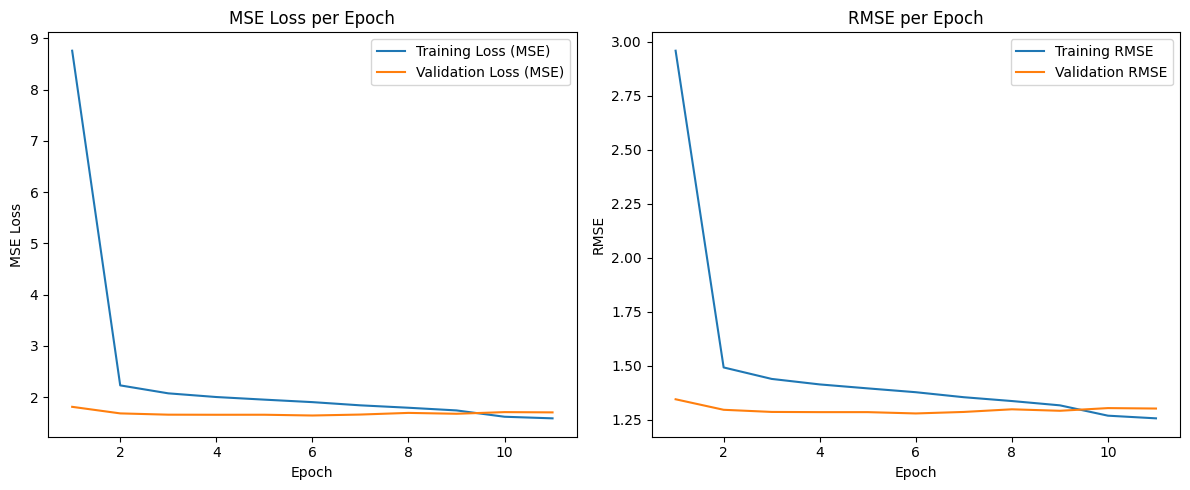

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

history = model.fit(
    x=[X_train[:, 0], X_train[:, 1]],
    y=y_train,
    batch_size=1024,
    epochs=20,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

train_loss = history.history['loss']
val_loss   = history.history.get('val_loss', [])
train_rmse = history.history['rmse']
val_rmse   = history.history.get('val_rmse', [])

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss (MSE)')
if val_loss:
    plt.plot(epochs, val_loss, label='Validation Loss (MSE)')
plt.title('MSE Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_rmse, label='Training RMSE')
if val_rmse:
    plt.plot(epochs, val_rmse, label='Validation RMSE')
plt.title('RMSE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

**Insight:**
- Model terbaik yang dihasilkan dengan nilai RMSE terbaik adalah pada epoch ke-6 dengan skor RMSE Training = 1.3668 dan RMSE Validation = 1.2795. Hasil ini mungkin bukan yang terbaik berhubung skor ada di atas 1 namun ini masih cukup memadai

## Evaluation

### Model 1: Content Based Filtering (CBF)

Rekomendasi berdasarkan judul anime

In [23]:
print(recommend_by_title('Fullmetal Alchemist', clean_anime, cosine_sim))


Rekomendasi untuk 'Fullmetal Alchemist':
No. Judul Anime                                       Similarity     Genre Match
----------------------------------------------------------------------------------------------------
1   Fullmetal Alchemist: The Sacred Star of Milos     1.0000          ✓
2   Fullmetal Alchemist: Brotherhood                  0.9735          ✓
3   Fullmetal Alchemist: Brotherhood Specials         0.9302          ✓
4   Tales of Vesperia: The First Strike               0.8515          ✓
5   Fullmetal Alchemist: Reflections                  0.8511          ✓
6   Tide-Line Blue                                    0.8108          ✓
7   Fairy Tail (2014)                                 0.7975          ✓
8   Fairy Tail                                        0.7975          ✓
9   Fairy Tail Movie 1: Houou no Miko                 0.7975          ✓
10  Fairy Tail x Rave                                 0.7975          ✓
Rata-rata Similarity : 0.8607
Precision@10     : 100.00%

Rekomendasi berdasarkan genre anime

In [24]:
print(recommend_by_genre('Action', clean_anime, cosine_sim))


Rekomendasi untuk genre: 'action':
No. Judul Anime                                       Similarity     Genre Match
----------------------------------------------------------------------------------------------------
1   Fullmetal Alchemist                               0.9735          ✓
2   Fullmetal Alchemist: The Sacred Star of Milos     0.9735          ✓
3   Fullmetal Alchemist: Brotherhood Specials         0.9555          ✓
4   Tales of Vesperia: The First Strike               0.8747          ✓
5   Tide-Line Blue                                    0.8329          ✓
6   Fullmetal Alchemist: Reflections                  0.8112          ✓
7   Magi: The Kingdom of Magic                        0.7848          ✓
8   Magi: The Labyrinth of Magic                      0.7848          ✓
9   Magi: Sinbad no Bouken (TV)                       0.7848          ✓
10  Magi: Sinbad no Bouken                            0.7848          ✓
Rata-rata Similarity: 0.8560 | Precision@10: 100.00%
Anime per

**Insight:**
- Dari hasil evaluasi pada kedua pendekatan model content based filtering (CBF). Dapat disimpulkan bahwa model sudah cukup memadai dengan skor kemiripan umumnya > 0.75 pada tingkat terendah dari 10 entri. Serta nilai precision at K=10 yang konsisten 100%

### Model 2: Collaborative Filtering (CF)

Tampil rekomendasi top-n
- Rekomendasi diambil dari anime yang belum ditonton oleh user lalu diurutkan berdasarkan nilai prediksi rating user tertinggi

In [34]:
def recommend_for_user(user_id, model, anime_df, top_n=10):
    if user_id not in user_id_to_idx:
        return f"User ID {user_id} tidak ditemukan"

    user_idx = user_id_to_idx[user_id]

    rated_anime = ratings_df[ratings_df['user_id'] == user_id]['anime_id'].unique()
    all_anime = anime_df['anime_id'].unique()
    unrated_anime = [aid for aid in all_anime if aid not in rated_anime]

    if not unrated_anime:
        return "Tidak ada anime baru untuk direkomendasikan"

    unrated_anime_idx = [anime_id_to_idx[aid] for aid in unrated_anime if aid in anime_id_to_idx]

    user_array = np.array([user_idx] * len(unrated_anime_idx))
    anime_array = np.array(unrated_anime_idx)

    predictions = model.predict([user_array, anime_array], verbose=0).flatten()

    top_indices = np.argsort(predictions)[-top_n:][::-1]

    recommendations = []
    for rank_idx, idx in enumerate(top_indices, start=1):
        anime_id = unrated_anime[idx]
        anime_info = anime_df[anime_df['anime_id'] == anime_id].iloc[0]
        recommendations.append({
            'rank': rank_idx,
            'anime_id': anime_id,
            'title': anime_info['name'],
            'genre': anime_info['genre'],
            'predicted_rating': predictions[idx],
            'global_rating': anime_info['rating']
        })

    print(f"\nRekomendasi untuk User {user_id}:")
    print("=" * 100)
    header = f"{'No.':<4} {'Judul Anime':<50} {'Predicted':<10} {'Global':<8} {'Genre'}"
    print(header)
    print("-" * 100)
    for rec in recommendations:
        title = rec['title']
        if len(title) > 47:
            title_display = title[:47] + "..."
        else:
            title_display = title

        print(f"{rec['rank']:<4} "
              f"{title_display:<50} "
              f"{rec['predicted_rating']:<10.4f} "
              f"{rec['global_rating']:<8.2f} "
              f"{rec['genre']}")
    print("=" * 100)

user_id = clean_ratings['user_id'].sample(1).iloc[0]
recommendations_df = recommend_for_user(user_id, model, clean_anime)


Rekomendasi untuk User 49503:
No.  Judul Anime                                        Predicted  Global   Genre
----------------------------------------------------------------------------------------------------
1    Ginga Eiyuu Densetsu                               9.3472     9.11     Drama, Military, Sci-Fi, Space
2    Gintama°                                           9.2306     9.25     Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen
3    Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gak... 9.0693     9.15     Comedy, Drama, School, Shounen, Sports
4    Fullmetal Alchemist: Brotherhood                   8.9858     9.26     Action, Adventure, Drama, Fantasy, Magic, Military, Shounen
5    Gintama&#039;: Enchousen                           8.8982     9.11     Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen
6    Qin Shiming Yue Zhi: Zhu Zi Bai Jia                8.8745     7.49     Action, Fantasy, Historical, Martial Arts
7    Gintama Movie: Kanketsu-hen - Y

**Insight:**
- Berdasarkan hasil sampel user 49503, sistem dapat merekomendasikan 10 anime yang diurut berdasarkan prediksi rating anime tersebut dengan apa yang diberi rating tinggi oleh user. Dapat diambil kesimpulan bahwa user id 49503 menyukai genre anime shounen dengan judul dan genre yang serupa pada list.